In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, f1_score, precision_score, recall_score
import json
from joblib import dump
import optuna
import matplotlib.pyplot as plt


def calculate_scale_pos_weight(y):
    neg, pos = np.bincount(y)
    return neg / pos
# Load data
df = pd.read_csv("/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/processed_data_with_demand_score.csv")

df = df[df['months_no_sale'] < 12]
df['obsolescence_dummy'] = (df['months_no_sale'] >= 6).astype(int)

drop_cols = ['part_number', 'description', 'supplier_name', 'sales_revenue', 'cogs', 'cost_per_unit',
             'months_no_sale', 'roi', 'rolling_12m_sales', 'margin', 'demand', 'quantity',
             'rolling_3m_sales', 'margin_percentage', 'gross_profit', 'sales_volatility', 'quantity_ordered_ytd',
             'negative_on_hand']
sales_columns = [f'sales_last_{month}' for month in ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']] + \
                [f'sales_{month}' for month in ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']]

X = df.drop(drop_cols + ['obsolescence_dummy'] + sales_columns, axis=1)
y = df['obsolescence_dummy']


# Stratified split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', MinMaxScaler())
        ]), numeric_features)
    ])

# Fit preprocessor and transform data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

scale_pos_weight = calculate_scale_pos_weight(y_train)
# Hyperparameter optimization using Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1e-3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-1, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 1000),
        'gamma': trial.suggest_float('gamma', 1e-5, 10.0, log=True)
    }
    
    model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    # Use stratified k-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, X_train_preprocessed, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    return scores.mean()
    

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

best_params = study.best_params

best_model = XGBClassifier(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

# Feature selection based on the best model
feature_importance = best_model.feature_importances_
feature_threshold = np.percentile(feature_importance, 75)  # Select top 25% features
selected_features = X.columns[feature_importance > feature_threshold].tolist()

# Create selected feature datasets
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', MinMaxScaler()),
        ]), selected_features)
    ]
)

# Train the final model on the selected features using training data
final_model = XGBClassifier(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train_selected, y_train)

final_pipeline = Pipeline([
    ('preprocessor', final_preprocessor),
    ('classifier', final_model)
])

final_pipeline.fit(X_train[selected_features], y_train)


def compute_scores(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    precision = precision_score(y, estimator.predict(X))
    recall = recall_score(y, estimator.predict(X))
    f1 = f1_score(y, estimator.predict(X))
    return {'auc': auc, 'precision': precision, 'recall': recall, 'f1': f1}

# Compute and print scores for the final model on validation set
val_scores = compute_scores(final_model, X_val_selected, y_val)
print("Final Model Performance (Validation Set):")
print(f"AUC = {val_scores['auc']:.4f}")
print(f"Precision = {val_scores['precision']:.4f}")
print(f"Recall = {val_scores['recall']:.4f}")
print(f"F1 score = {val_scores['f1']:.4f}")

# Calibration
calibration_methods = ['sigmoid', 'isotonic', None]
calibrated_models = {}
calibration_scores = {}

for method in calibration_methods:
    if method is not None:
        calibrator = CalibratedClassifierCV(final_model, cv=10, method=method)
        calibrated_model = calibrator.fit(X_train_selected, y_train)
        calibrated_models[method] = calibrated_model
    else:
        calibrated_models[method] = final_model
    
    # Evaluate on validation set
    y_pred_proba = calibrated_models[method].predict_proba(X_val_selected)[:, 1]
    brier_score = brier_score_loss(y_val, y_pred_proba)
    log_loss_score = log_loss(y_val, y_pred_proba)
    
    scores = compute_scores(calibrated_models[method], X_val_selected, y_val)
    
    calibration_scores[method] = {
        'brier_score': brier_score,
        'log_loss': log_loss_score,
        'auc': scores['auc'],
        'precision': scores['precision'],
        'recall': scores['recall'],
        'f1': scores['f1']
    }

# Print calibration scores
print("\nCalibration and performance scores (Validation Set):")
for method, scores in calibration_scores.items():
    print(f"\n{method if method else 'No calibration'}:")
    print(f"  Brier score = {scores['brier_score']:.4f}")
    print(f"  Log loss = {scores['log_loss']:.4f}")
    print(f"  AUC = {scores['auc']:.4f}")
    print(f"  Precision = {scores['precision']:.4f}")
    print(f"  Recall = {scores['recall']:.4f}")
    print(f"  F1 score = {scores['f1']:.4f}")

# Select best calibration method based on AUC
best_method = max(calibration_scores, key=lambda x: calibration_scores[x]['auc'])
print(f"\nBest calibration method (based on AUC): {best_method if best_method else 'No calibration'}")

# Final evaluation on test set
best_calibrated_model = calibrated_models[best_method]
test_scores = compute_scores(best_calibrated_model, X_test_selected, y_test)
print("\nFinal Model Performance (Test Set):")
print(f"AUC = {test_scores['auc']:.4f}")
print(f"Precision = {test_scores['precision']:.4f}")
print(f"Recall = {test_scores['recall']:.4f}")
print(f"F1 score = {test_scores['f1']:.4f}")

best_method = max(calibration_scores, key=lambda x: calibration_scores[x]['auc'])

print("Calibration and performance scores:")
for method, scores in calibration_scores.items():
    print(f"\n{method if method else 'No calibration'}:")
    print(f"  Brier score = {scores['brier_score']:.4f}")
    print(f"  Log loss = {scores['log_loss']:.4f}")
    print(f"  AUC = {scores['auc']:.4f}")
    print(f"  Precision = {scores['precision']:.4f}")
    print(f"  Recall = {scores['recall']:.4f}")
    print(f"  F1 score = {scores['f1']:.4f}")

print(f"\nBest calibration method (based on AUC): {best_method if best_method else 'No calibration'}")

# Plot calibration curves
plt.figure(figsize=(10, 10))
for method in calibration_methods:
    if method is not None:
        clf_name = f'Calibrated {method}'
    else:
        clf_name = 'No calibration'
    
    y_pred_proba = calibrated_models[method].predict_proba(X_test_selected)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)
    
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{clf_name}")

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves")
plt.legend()
plt.savefig('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/obsolecence_predictor/calibration_curves.png')
plt.close()

# Save the best calibrated model
best_calibrated_model = calibrated_models[best_method]
dump(final_preprocessor, '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/obsolecence_predictor/preprocessor.joblib')
dump(best_calibrated_model, '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/obsolecence_predictor/best_calibrated_random_forest_model.joblib')

best_params_and_features = {
    'selected_features': selected_features,
    'best_hyperparameters': best_params,
    'best_calibration_method': best_method if best_method else 'No calibration',
    'calibration_scores': calibration_scores
}

with open('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/obsolecence_predictor/general_model_details.json', 'w') as file:
    json.dump(best_params_and_features, file, indent=4)




[I 2024-08-05 08:32:14,877] A new study created in memory with name: no-name-ccb5231e-90c9-4e7f-9d6b-26b319219ab9
[I 2024-08-05 08:32:19,337] Trial 0 finished with value: 0.9617867469022384 and parameters: {'n_estimators': 112, 'max_depth': 2, 'learning_rate': 2.377182083644168e-05, 'subsample': 0.7532456050879818, 'colsample_bytree': 0.9777030452376194, 'reg_alpha': 0.33661714898270195, 'reg_lambda': 3.9000653768904234, 'min_child_weight': 6, 'max_leaves': 556, 'gamma': 0.025166009528859317}. Best is trial 0 with value: 0.9617867469022384.
[I 2024-08-05 08:32:22,504] Trial 1 finished with value: 0.9897291691703188 and parameters: {'n_estimators': 453, 'max_depth': 9, 'learning_rate': 2.910145573996222e-07, 'subsample': 0.9263857888311067, 'colsample_bytree': 0.7934472749134701, 'reg_alpha': 0.14797343876247018, 'reg_lambda': 0.22440706352647055, 'min_child_weight': 7, 'max_leaves': 797, 'gamma': 1.1568583979933071}. Best is trial 1 with value: 0.9897291691703188.
[I 2024-08-05 08:32:2

Final Model Performance (Validation Set):
AUC = 0.8194
Precision = 0.0000
Recall = 0.0000
F1 score = 0.0000


/Users/skylerwilson/miniconda3/envs/partsmatch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/skylerwilson/miniconda3/envs/partsmatch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Calibration and performance scores (Validation Set):

sigmoid:
  Brier score = 0.2373
  Log loss = 0.6676
  AUC = 0.0418
  Precision = 0.0000
  Recall = 0.0000
  F1 score = 0.0000

isotonic:
  Brier score = 0.0467
  Log loss = 0.1642
  AUC = 0.9795
  Precision = 0.9481
  Recall = 0.9043
  F1 score = 0.9257

No calibration:
  Brier score = 0.2373
  Log loss = 0.6676
  AUC = 0.8194
  Precision = 0.0000
  Recall = 0.0000
  F1 score = 0.0000

Best calibration method (based on AUC): isotonic

Final Model Performance (Test Set):
AUC = 0.9800
Precision = 0.9618
Recall = 0.9142
F1 score = 0.9374
Calibration and performance scores:

sigmoid:
  Brier score = 0.2373
  Log loss = 0.6676
  AUC = 0.0418
  Precision = 0.0000
  Recall = 0.0000
  F1 score = 0.0000

isotonic:
  Brier score = 0.0467
  Log loss = 0.1642
  AUC = 0.9795
  Precision = 0.9481
  Recall = 0.9043
  F1 score = 0.9257

No calibration:
  Brier score = 0.2373
  Log loss = 0.6676
  AUC = 0.8194
  Precision = 0.0000
  Recall = 0.0000


Final Model Performance (Test Set):
AUC = 0.9800
Precision = 0.9618
Recall = 0.9142
F1 score = 0.9374


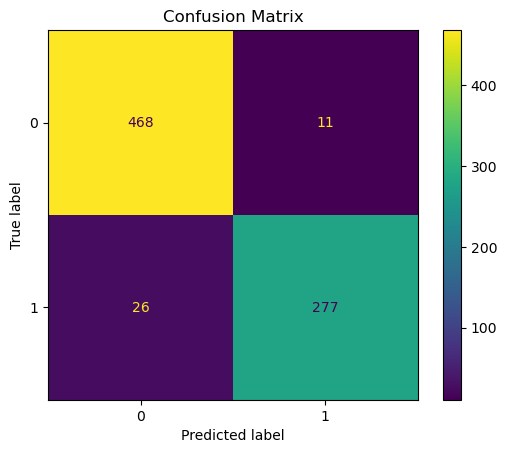

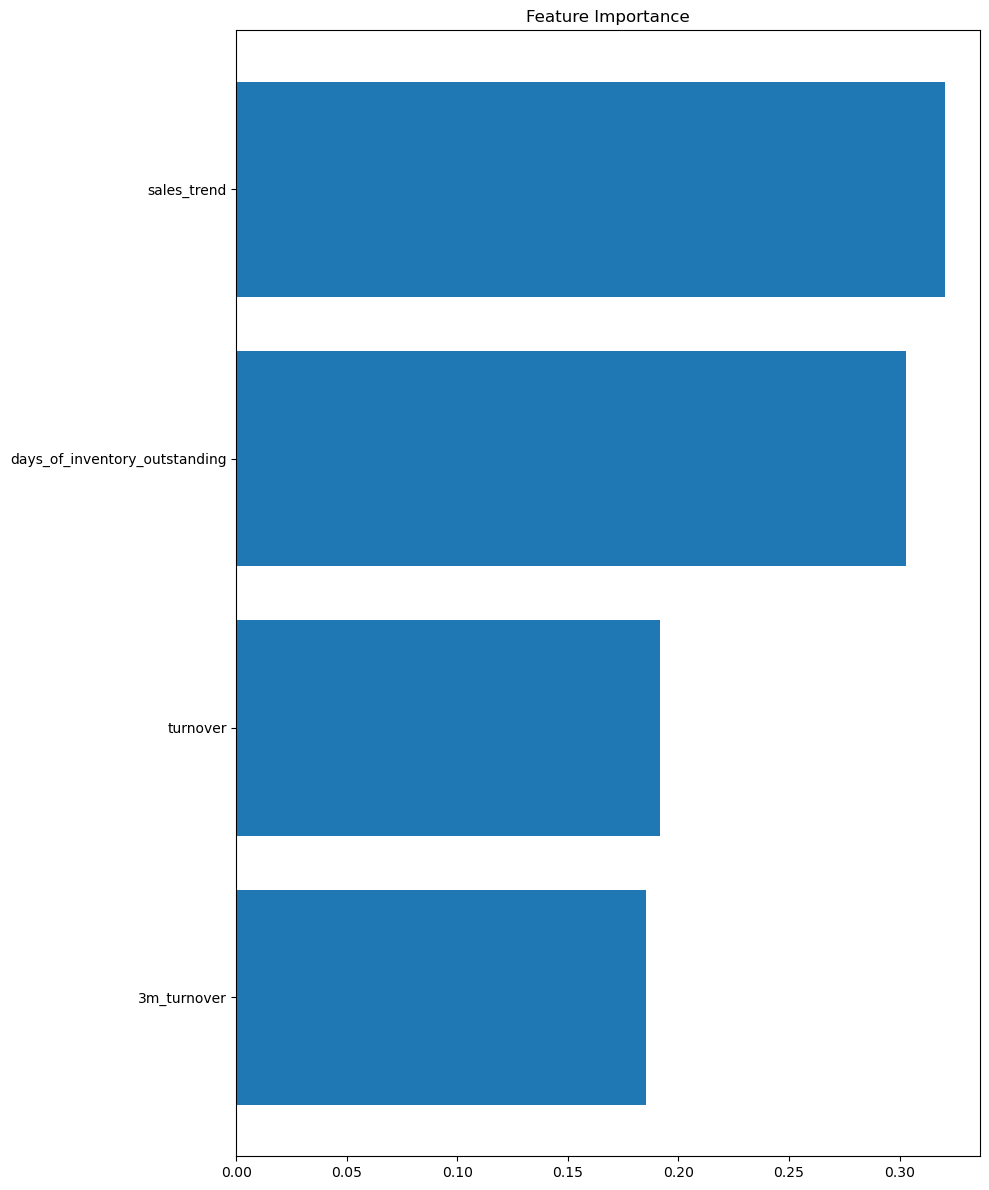

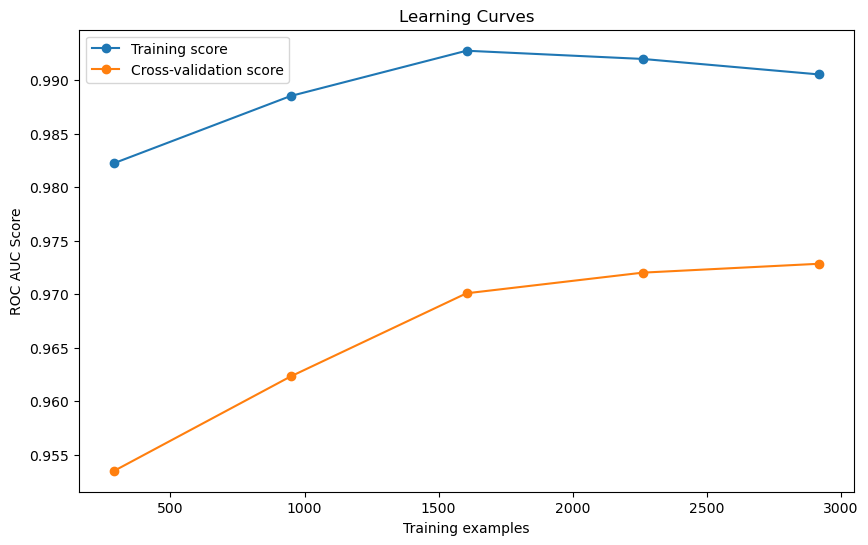

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Final evaluation on test set
best_calibrated_model = calibrated_models[best_method]
test_scores = compute_scores(best_calibrated_model, X_test_selected, y_test)
print("\nFinal Model Performance (Test Set):")
print(f"AUC = {test_scores['auc']:.4f}")
print(f"Precision = {test_scores['precision']:.4f}")
print(f"Recall = {test_scores['recall']:.4f}")
print(f"F1 score = {test_scores['f1']:.4f}")

# Confusion Matrix
y_pred = best_calibrated_model.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
feature_importance = final_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig, ax = plt.subplots(figsize=(10, 12))
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(np.array(selected_features)[sorted_idx])
ax.set_title('Feature Importance')
plt.tight_layout()
plt.show()

# Learning Curves
train_sizes, train_scores, val_scores = learning_curve(
    final_model, X_train_selected, y_train, train_sizes=np.linspace(.1, 1.0, 5),
    scoring='roc_auc', n_jobs=-1, cv=5)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()

In [8]:
print("Class distribution:")
print(y.value_counts(normalize=True))

Class distribution:
obsolescence_dummy
0    0.612817
1    0.387183
Name: proportion, dtype: float64


Feature Importances:
                      Feature  Importance
                  sales_trend    0.269609
                  3m_turnover    0.213858
                     turnover    0.184272
days_of_inventory_outstanding    0.154804
                anomaly_score    0.043710
                  consistency    0.035256
            sell_through_rate    0.018598
           recent_sales_trend    0.015933
         seasonality_strength    0.013637
             recurrence_score    0.011036
           special_orders_ytd    0.008696
                   total_cost    0.007763
               3m_days_supply    0.007293
              12m_days_supply    0.004560
               1m_days_supply    0.003959
                        price    0.003893
         order_to_sales_ratio    0.003125


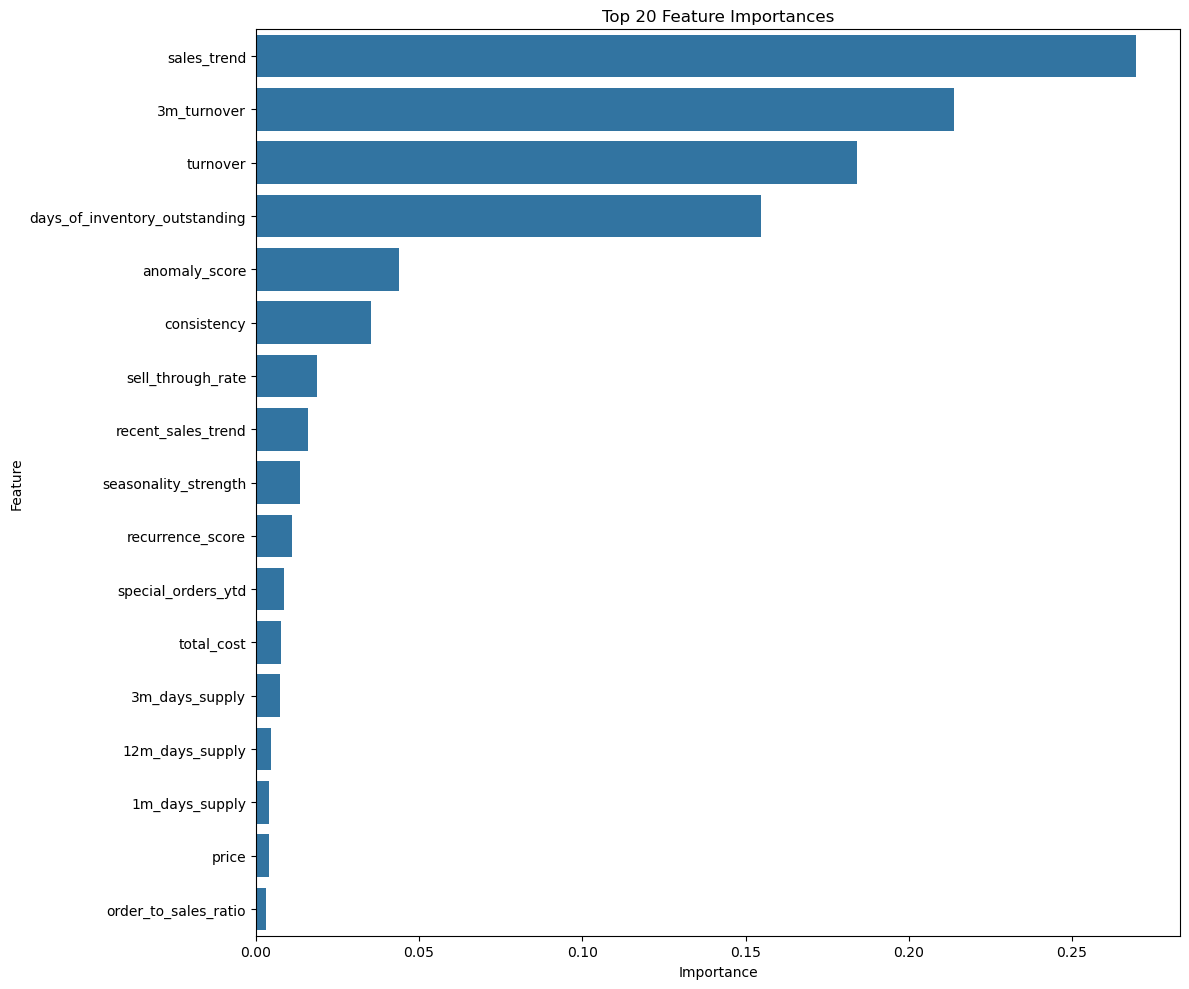

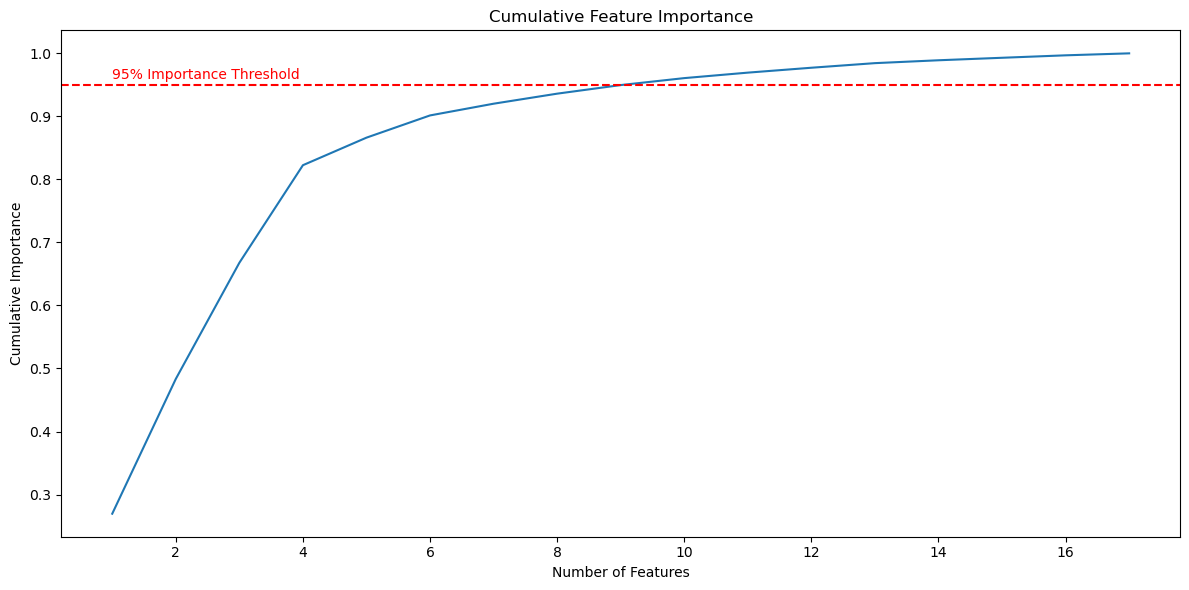


Number of features explaining 95% of the importance: 6

Top features explaining 95% of the importance:
                      Feature  Importance
                  sales_trend    0.269609
                  3m_turnover    0.213858
                     turnover    0.184272
days_of_inventory_outstanding    0.154804
                anomaly_score    0.043710
                  consistency    0.035256


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming best_model is your trained XGBoost model
feature_importances = best_model.feature_importances_

# Create a pandas DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Use X_train.columns instead of feature_names
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance DataFrame
print("Feature Importances:")
print(feature_importance_df.to_string(index=False))

# Plotting feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))  # Show top 20 features
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print cumulative importance
cumulative_importance = feature_importance_df['Importance'].cumsum()
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance)
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.text(1, 0.96, '95% Importance Threshold', color='r')
plt.tight_layout()
plt.show()

# Find number of features for 95% cumulative importance
n_features_95 = (cumulative_importance > 0.95).idxmax()
print(f"\nNumber of features explaining 95% of the importance: {n_features_95}")

# Print top features explaining 95% of the importance
print("\nTop features explaining 95% of the importance:")
print(feature_importance_df.head(n_features_95).to_string(index=False))

In [10]:
import polars as pl
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Read the CSV file
df = pl.read_csv("/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/processed_data_with_demand_score.csv")

# Exclude obsolete items and assign obsolescence_dummy
df = df.filter(pl.col('months_no_sale') < 12)
df = df.with_columns(
    pl.when(pl.col('months_no_sale') > 6)
    .then(1)
    .otherwise(0)
    .alias('obsolescence_dummy')
)

# Define features and target variable
drop_cols = ['part_number', 'description', 'supplier_name', 'sales_revenue', 'cogs', 'cost_per_unit',
             'months_no_sale', 'roi', 'rolling_12m_sales', 'margin', 'demand', 'quantity',
             'rolling_3m_sales', 'margin_percentage', 'sales_volatility']
sales_columns = ['sales_last_jan','sales_last_feb', 'sales_last_mar', 'sales_last_apr', 'sales_last_may',
                 'sales_last_jun', 'sales_last_jul', 'sales_last_aug', 'sales_last_sep',
                 'sales_last_oct', 'sales_last_nov', 'sales_last_dec', 'sales_jan',
                 'sales_feb', 'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 
                 'sales_jul', 'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 'sales_dec']
X = df.drop(drop_cols + ['obsolescence_dummy'] + sales_columns)

# Calculate VIF
vif_data = pl.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.to_numpy(), i) for i in range(len(X.columns))]
})

vif_data

feature,VIF
str,f64
"""special_orders_ytd""",1.269656
"""price""",1.538835
"""quantity_ordered_ytd""",1.110426
"""negative_on_hand""",1.124478
"""total_cost""",1.426104
…,…
"""sell_through_rate""",2.207565
"""days_of_inventory_outstanding""",1.030237
"""order_to_sales_ratio""",1.063744
